In [4]:
import pandas as pd
import numpy as np
from scipy.interpolate import LinearNDInterpolator, interp1d, make_smoothing_spline
import matplotlib.pyplot as plt
import matplotlib as mm
from astropy.io.votable import parse_single_table
import glob
import re

import sys
import astropy
from astropy.io import fits

import scipy 


def grid_builder(path_to_models, target_wv):

    data = {}

    models = glob.glob(f'{path_to_models}da*_*.dk.dat.xml')

    for name in models:
        print(re.findall(r'\d+', name)[:], end = '\r')
        model = parse_single_table(f'{name}').to_table(use_names_over_ids=True)

        wv, f = model['WAVELENGTH'], model['FLUX']

        s = 1e4 / wv

        wv_air = (1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - (s**2)) + 0.0001599740894897 / (38.92568793293 - (s**2))) * wv

        interpolator = interp1d(wv_air, f)

        flux_ = interpolator(target_wv)

        par = re.findall(r'\d+', name)
        teff = int(par[-2])
        logg = int(par[-1])
        #print(teff, logg)
        #print(name)
        if teff not in data.keys():
            data[teff] = {}

        data[teff][logg] = flux_

    print('')
    return data, target_wv


def normalizer(wl, fl, lam = 1e2):

    cmask = (
        ((wl > 7000) * (wl < 7500)) +\
        ((wl > 5150) * (wl < 6100)) +\
        ((wl > 4600) * (wl < 4650)) +\
        ((wl > 4200) * (wl < 4220)) +\
        ((wl > 4030) * (wl < 4035)) +\
        ((wl > 3926.5) * (wl < 3928.6)) +\
        ((wl > 3859.3) * (wl < 3861.5)) +\
        ((wl > 3782) * (wl < 3777)) +\
        ((wl > np.min(wl)) * (wl < np.min(wl) + 100)) +\
        ((wl > 3500) * (wl < 3700)) +\
        
        (wl > 7500)
        )


    cmask_balmer = (
    ((wl > 6413) * (wl < 6713)) +\
    ((wl > 4761) * (wl < 4971)) +\
    ((wl > 4281) * (wl < 4401)) +\
    ((wl > 4067) * (wl < 4137)) +\
    ((wl > 3945) * (wl < 3995)) +\
    ((wl > 3876.5) * (wl < 3901.5)))


    
    cont = make_smoothing_spline(wl[cmask&(~cmask_balmer)], fl[cmask&(~cmask_balmer)], lam=lam)(wl)

    return cont
    


In [5]:
path_to_models = '/home/vale/Desktop/puc_cluster/GRID/da_models_sel/'
target_wv = np.arange(3500, 9000, 0.5)
data, target_wv = grid_builder(path_to_models, target_wv)

['09500', '950']


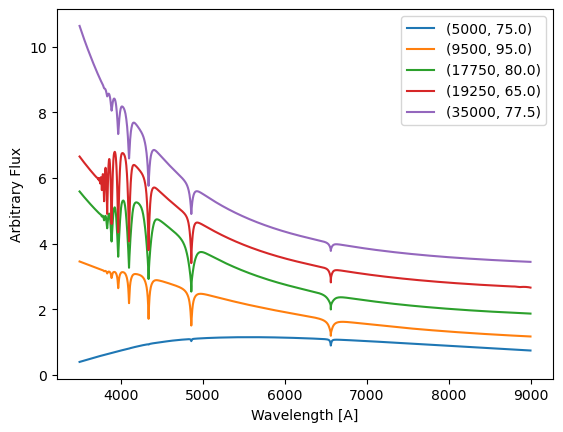

In [6]:
i = 0
for t in np.sort(list(data.keys())):
    for logg in list(data[t].keys()):

        plt.plot(target_wv, data[t][logg]/np.median(data[t][logg]) + 0.8*i, label = (t, logg*1e-1))
        i+=1
plt.xlabel('Wavelength [A]')
plt.ylabel('Arbitrary Flux')

plt.legend()
plt.show()

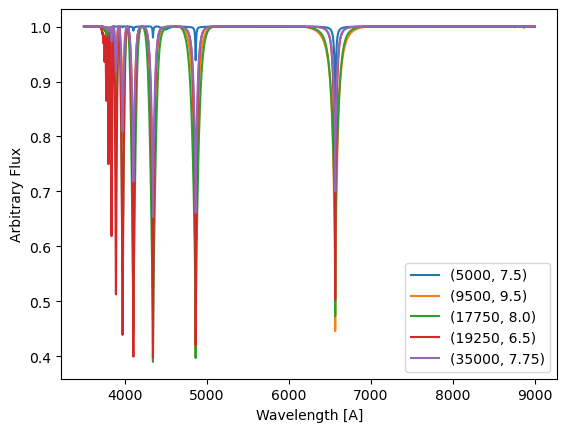

In [7]:
for t in np.sort(list(data.keys())):
    for logg in list(data[t].keys()):
    
        cont = normalizer(target_wv, data[t][logg], lam = 1000)

        plt.plot(target_wv, data[t][logg]/cont, label = (t, logg*1e-2))
plt.xlabel('Wavelength [A]')
plt.ylabel('Arbitrary Flux')

plt.legend()
plt.show()

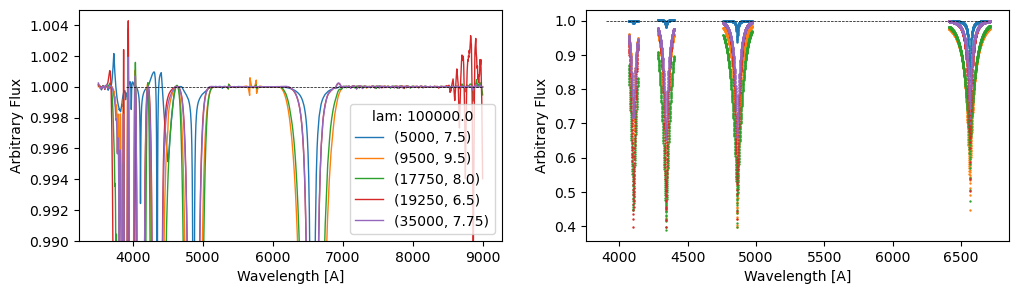

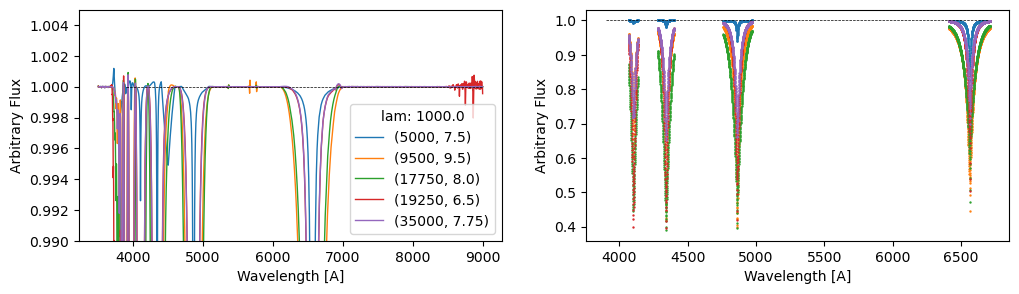

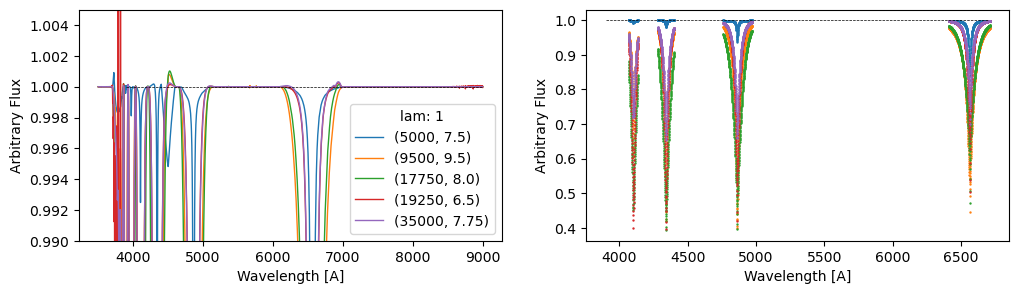

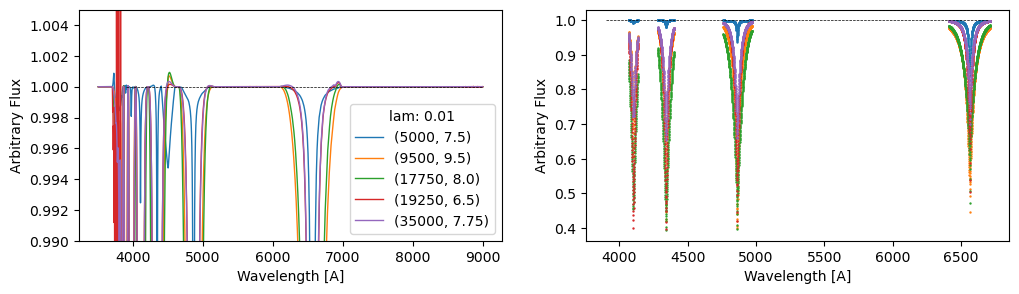

In [8]:
cmask_balmer = (
    ((target_wv > 6413) * (target_wv < 6713)) +\
    ((target_wv > 4761) * (target_wv < 4971)) +\
    ((target_wv > 4281) * (target_wv < 4401)) +\
    ((target_wv > 4067) * (target_wv < 4137)))

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,3))

lam = 1e5
for t in np.sort(list(data.keys())):
    for logg in list(data[t].keys()):
    
        cont = normalizer(target_wv, data[t][logg], lam = lam)
        axs[0].plot(target_wv, data[t][logg]/cont, label = (t, logg*1e-2),  zorder = -1, lw = 1)
        axs[1].scatter(target_wv[cmask_balmer], data[t][logg][cmask_balmer]/cont[cmask_balmer], label = (t, logg*1e-2),  zorder = -1, lw = 1, s = 0.5)

axs[0].legend(title = f'lam: {lam}')
axs[0].hlines(y = 1, xmin = 3900, xmax = 9000, linestyle = '--', lw = 0.5, color = 'k')
axs[1].hlines(y = 1, xmin = 3900, xmax = 6700, linestyle = '--', lw = 0.5, color = 'k')
axs[0].set_xlabel('Wavelength [A]')
axs[0].set_ylabel('Arbitrary Flux')
axs[1].set_xlabel('Wavelength [A]')
axs[1].set_ylabel('Arbitrary Flux')

axs[0].set_ylim(0.99,1.005)
plt.show()



fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,3))

lam = 1e3
for t in np.sort(list(data.keys())):
    for logg in list(data[t].keys()):
    
        cont = normalizer(target_wv, data[t][logg], lam = lam)
        axs[0].plot(target_wv, data[t][logg]/cont, label = (t, logg*1e-2),  zorder = -1, lw = 1)
        axs[1].scatter(target_wv[cmask_balmer], data[t][logg][cmask_balmer]/cont[cmask_balmer], label = (t, logg*1e-2),  zorder = -1, lw = 1, s = 0.5)

axs[0].legend(title = f'lam: {lam}')
axs[0].hlines(y = 1, xmin = 3900, xmax = 9000, linestyle = '--', lw = 0.5, color = 'k')
axs[1].hlines(y = 1, xmin = 3900, xmax = 6700, linestyle = '--', lw = 0.5, color = 'k')
axs[0].set_xlabel('Wavelength [A]')
axs[0].set_ylabel('Arbitrary Flux')
axs[1].set_xlabel('Wavelength [A]')
axs[1].set_ylabel('Arbitrary Flux')

axs[0].set_ylim(0.99,1.005)
plt.show()

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,3))

lam = 1
for t in np.sort(list(data.keys())):
    for logg in list(data[t].keys()):
    
        cont = normalizer(target_wv, data[t][logg], lam = lam)
        axs[0].plot(target_wv, data[t][logg]/cont, label = (t, logg*1e-2),  zorder = -1, lw = 1)
        axs[1].scatter(target_wv[cmask_balmer], data[t][logg][cmask_balmer]/cont[cmask_balmer], label = (t, logg*1e-2),  zorder = -1, lw = 1, s = 0.5)

axs[0].legend(title = f'lam: {lam}')
axs[0].hlines(y = 1, xmin = 3900, xmax = 9000, linestyle = '--', lw = 0.5, color = 'k')
axs[1].hlines(y = 1, xmin = 3900, xmax = 6700, linestyle = '--', lw = 0.5, color = 'k')
axs[0].set_xlabel('Wavelength [A]')
axs[0].set_ylabel('Arbitrary Flux')
axs[1].set_xlabel('Wavelength [A]')
axs[1].set_ylabel('Arbitrary Flux')

axs[0].set_ylim(0.99,1.005)
plt.show()



fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,3))

lam = 1e-2
for t in np.sort(list(data.keys())):
    for logg in list(data[t].keys()):
    
        cont = normalizer(target_wv, data[t][logg], lam = lam)
        axs[0].plot(target_wv, data[t][logg]/cont, label = (t, logg*1e-2),  zorder = -1, lw = 1)
        axs[1].scatter(target_wv[cmask_balmer], data[t][logg][cmask_balmer]/cont[cmask_balmer], label = (t, logg*1e-2),  zorder = -1, lw = 1, s = 0.5)

axs[0].legend(title = f'lam: {lam}')
axs[0].hlines(y = 1, xmin = 3900, xmax = 9000, linestyle = '--', lw = 0.5, color = 'k')
axs[1].hlines(y = 1, xmin = 3900, xmax = 6700, linestyle = '--', lw = 0.5, color = 'k')
axs[0].set_xlabel('Wavelength [A]')
axs[0].set_ylabel('Arbitrary Flux')
axs[1].set_xlabel('Wavelength [A]')
axs[1].set_ylabel('Arbitrary Flux')

axs[0].set_ylim(0.99,1.005)
plt.show()


In [ ]:
28.77, 8.43